# Drug-likeness of recombined ligands vs. PKIDB ligands

In order to assess the drug-likeness of our > 15M recombined ligands,

* calculate the drug-likeness of our recombined ligands and 
* compare it to the drug-likeness of ligands from the PKIDB, which are approved and investigorial kinase inhibitors and therefore give an idea on how an ideal kinase inhibitor's drug-likeness looks like.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem, PandasTools
from rdkit.Chem.Draw import IPythonConsole

import kinase_focused_fragment_library as kffl
import klifs_utils as klifs

RDKit WARNING: [14:14:55] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
url = 'https://raw.githubusercontent.com/dominiquesydow/pkidb_klifs/master/results/pkidb_20200218.csv'

In [4]:
PROJECT_PATH = Path('/home/dominique/Documents/Projects/KinaseFocusedFragmentLibraryData')

recomb_ligands_path = PROJECT_PATH / 'CombinatorialLibrary' / 'combinatorial_library.pickle'
fragment_path = PROJECT_PATH / 'FragmentLibrary/'

## Load ligand data

### PKIDB ligands

PKIDB ligands: approved and investigorial kinase inhibitors

In [5]:
pkidb_ligands = pd.read_csv(url, index_col=0)
print(f'PKIDB ligands: {pkidb_ligands.shape[0]}')

PKIDB ligands: 218


### Original ligands

In [6]:
def get_ligands(data_path, kinase_structure_pairs):
    
    mols = []
    
    for i, kinase_structure_pair in kinase_structure_pairs.iterrows():
        
        mol = klifs.ligands.mol_from_mol2(
            data_path, 
            kinase_structure_pair.species, 
            kinase_structure_pair.kinase, 
            kinase_structure_pair.klifs_code
        )
        mols.append(mol)
        
    return mols

In [7]:
# Load fragment library
fragment_library = kffl.analysis.fragment_analysis.util.read_fragment_library(fragment_path, remove_dummy=True)

# Get deduplicated kinase-structure pairs
kinase_structure_pairs = kffl.analysis.fragment_analysis.util.get_deduplicated_original_complexes(fragment_library)
kinase_structure_pairs['species'] = 'HUMAN'

# Get ligands
original_ligands = get_ligands(PROJECT_PATH, kinase_structure_pairs)

Fragments: 7486
Deduplicated kinase-structure pairs from which fragments originate: 2553


### Recombined ligands

In [8]:
ligand_indices_deduplicated = kffl.analysis.ligand_analysis.util.load_ligand_indices_deduplicated(
    recomb_ligands_path.parent / 'unique_molecule_ids.txt'
)

recombined_ligands_properties = kffl.analysis.ligand_analysis.util.load_combinatorial_library_properties(
    recomb_ligands_path.parent / 'combinatorial_library_properties.csv',
    ligand_indices_deduplicated[0:3]
)

Full library: 7
Ligand indices of deduplicated library entries: 3
Deduplicated library: 3


## Get drug-likeness

### PKIDB ligands

In [9]:
drug_likeness_pkidb = kffl.analysis.ligand_analysis.util.drug_likeness_from_smiles(pkidb_ligands.Canonical_Smiles)

Number of molecules: 218


### Original ligands

In [10]:
drug_likeness_klifs = kffl.analysis.ligand_analysis.util.drug_likeness_from_mols(original_ligands)

Number of molecules: 2553


### Recombined ligands

In [11]:
drug_likeness_recomb = kffl.analysis.ligand_analysis.util.drug_likeness_from_combinatorial_library(recombined_ligands_properties)
# [24.6, 63.6, 95.5, 55.9, 39.5]

## Plot drug likeness

In [12]:
bar_data = pd.DataFrame([drug_likeness_recomb, drug_likeness_klifs, drug_likeness_pkidb])
bar_data.index = ['Recombined ligands', 'Original ligands (KLIFS)', 'PKIDB ligands']
bar_data = bar_data.transpose()
bar_data = bar_data.astype('int32')
bar_data

,Recombined ligands,Original ligands (KLIFS),PKIDB ligands
mw,33,88,70
logp,33,94,74
hbd,100,99,100
hba,67,99,99
lipinski,33,97,85


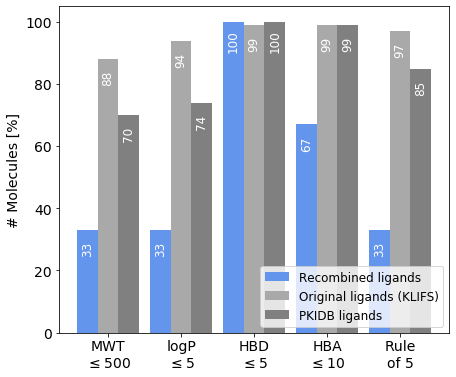

In [13]:
# Plot data
ax = bar_data.plot(
    kind='bar',
    width=0.85,
    rot=0,
    figsize=(7, 6),
    color=['cornflowerblue', 'darkgrey', 'grey']
)

# Edit labels for y axis and x/y ticks
plt.ylabel('# Molecules [%]', fontsize=14)
plt.xticks(range(5), ['MWT\n'+r'$\leq 500$', 'logP\n'+r'$\leq 5$', 'HBD\n'+r'$\leq 5$', 'HBA\n'+r'$\leq 10$', 'Rule\nof 5'], fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=12, loc='lower right')
#plt.ylim([120, 1])

# Add percentages to bars
bars = ax.patches
bar_labels = bar_data.transpose().values.flatten()
for bar, label in zip(bars, bar_labels):
    
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        bar.get_height() - 6,
        label, 
        ha='center', 
        va='center', 
        fontsize=12,
        color='white',
        rotation=90
    )

In [14]:
ax.get_figure().savefig('/home/dominique/Desktop/ra_lipinski.pdf')